In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

#you can add data yourself to add on more emojis

In [3]:
# shuffle data together
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices]

indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]


In [4]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train. 
* Change `idx` to see different examples. 
* Note that due to the font used by iPython notebook, the heart emoji may be colored black rather than red.

In [5]:
for idx in range(30):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

I got approved 😄
Bravo for the announcement it got a lot of traction 😄
her smile is so charming 😄
Congrats on the new job 😄
he is the best player ⚾
I am at the baseball game ⚾
do you have a ball ⚾
you two are cute ❤️
The chicago cubs won again ⚾
I am hungry 🍴
That catcher sucks  ⚾
too bad that you were not here 😞
I want chinese food 🍴
What is wrong with you 😞
I like you a lot ❤️
the game just finished ⚾
I want to go play ⚾
Lets have food together 🍴
my code is working but the grader gave me zero 😞
She is the cutest person I have ever seen ❤️
what are the rules of the game ⚾
The first base man got the ball ⚾
I am proud of you forever 😄
Who is your favorite player ⚾
she is happy 😄
she is attractive ❤️
It was funny lol 😄
I love dogs ❤️
do you like pizza  🍴
you failed the midterm 😞


In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = num_emoji) # number of classes
Y_oh_test = convert_to_one_hot(Y_test, C = num_emoji)

In [7]:
idx = 25
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I am ordering food' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0. 0.]


In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')
#data in the link https://drive.google.com/file/d/1_YK1uZfJEIWq07U2AMnP7YxKBrMNp6Z1/view?usp=sharing
#can see code on git username:samg2003

In [10]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [11]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    #Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(len(words))
    
    # average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        total += word_to_vec_map[w]
    avg = total/len(words)

    
    return avg

In [12]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]



$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$


In [13]:
#above are backpropagation formulas
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = num_emoji                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -1* np.sum(Y_oh[i]*np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(num_emoji)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(num_emoji)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)
(132,)
(132, 6)
I got approved
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 6)
<class 'numpy.ndarray'>


Run the next cell to train your model and learn the softmax parameters (W,b). 

In [15]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

#fitting shallow model

Epoch: 0 --- cost = 1.2831774041293813
Accuracy: 0.30303030303030304
Epoch: 100 --- cost = 0.0751241814652397
Accuracy: 0.9090909090909091
Epoch: 200 --- cost = 0.02838781687058916
Accuracy: 0.9393939393939394
Epoch: 300 --- cost = 0.015329640459375194
Accuracy: 0.9621212121212122
[[2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [4.]
 [1.]
 [3.]
 [4.]
 [3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [3.]
 [0.]
 [1.]
 [1.]
 [2.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [4.]
 [3.]
 [2.]
 [4.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [3.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [4.]
 [2.]
 [3.]
 [2.]
 [4.]
 [0.]
 [3.]
 [4.]
 [3.]
 [3.]
 [1.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [4.]
 [2.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [2.]
 [0.]
 [3.]
 [4.]
 [4.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [2.]
 [0.]
 [0.]
 [3.]
 [3.]
 [0.]
 [3.]
 [1.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [0.]
 [1.]
 [3.]
 [3.]
 [0.]
 [3.]
 [3.]
 [4.]
 [1.]
 [3.]
 [3.]
 [3.

In [16]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9696969696969697
Test set:
Accuracy: 0.875


In [17]:
X_my_sentences = np.array(["i adore you", "hi i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 1.0

i adore you ❤️
hi i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😞


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    0    0    7    7
All          9    9   18   13    7   56


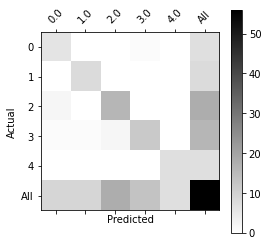

In [18]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

##  Emojifier -- Using LSTMs in Keras: 


In [19]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [20]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx,val)

0 I
1 like
2 learning


In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1

    return X_indices

In [22]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [23]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    

    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len,emb_dim,trainable = False)


    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [25]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape = input_shape, dtype="int32")
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128,return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128,return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = num_emoji)(X) # number of classes
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [26]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774 

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [28]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = num_emoji)  #number of classes

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)
#previous was example of simple shallow neural network and this is example of deep model with lstm's 


Epoch 1/50
132/132 [==============================] - 1s 6ms/step - loss: 1.6860 - accuracy: 0.2879
Epoch 2/50
132/132 [==============================] - 0s 615us/step - loss: 1.5697 - accuracy: 0.3333
Epoch 3/50
132/132 [==============================] - 0s 633us/step - loss: 1.5021 - accuracy: 0.3712
Epoch 4/50
132/132 [==============================] - 0s 791us/step - loss: 1.4669 - accuracy: 0.3561
Epoch 5/50
132/132 [==============================] - 0s 821us/step - loss: 1.3706 - accuracy: 0.4394
Epoch 6/50
132/132 [==============================] - 0s 731us/step - loss: 1.3085 - accuracy: 0.5303
Epoch 7/50
132/132 [==============================] - 0s 904us/step - loss: 1.1335 - accuracy: 0.5606
Epoch 8/50
132/132 [==============================] - 0s 747us/step - loss: 1.1014 - accuracy: 0.5909
Epoch 9/50
132/132 [==============================] - 0s 700us/step - loss: 0.9013 - accuracy: 0.6818
Epoch 10/50
132/132 [==============================] - 0s 702us/step - loss: 0.8645

In [31]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = num_emoji)  # number of classes
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)
#clearly its overfitting.. hyperparameters are not tuned

56/56 [==============================] - 0s 210us/step

Test accuracy =  0.8928571343421936


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

In [32]:
# This code allows you to see the mislabelled examples
C = num_emoji #number of classes
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️


In [33]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(["i play"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

i play ⚾


In [34]:
x_tests = np.array(["I had a disappointing day", "I am excited about this journey","lets have something to eat","hi Mother","i will play","not feeling happy","hello"])
for i in range(x_tests.shape[0]):
    x_test = np.array([x_tests[i]])
    X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
    print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I had a disappointing day 😄
I am excited about this journey 😄
lets have something to eat 🍴
hi Mother ❤️
i will play ⚾
not feeling happy 😞
hello 😄


In [35]:
#there is not regularization for unexpected output!!!
#so it can cause undesirable outputs like discrimination